In [21]:
import pandas as pd
import shap
import joblib
from keras.models import load_model

In [22]:
df = pd.read_csv('best_model/engineered_data.csv')

In [23]:
dnn = load_model('best_model/best_model.keras')
prep = joblib.load('best_model/best_preprocssor.joblib')

In [24]:
X = df.drop(['Salary'], axis = 1)
y = df['Salary']

In [25]:
X_prep = prep.transform(X)

In [26]:
expected_value = dnn.predict(X_prep).mean()

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [27]:
explainer = shap.Explainer(dnn, X_prep)

In [28]:
shap_values = explainer.shap_values(X_prep)

Permutation explainer: 5061it [20:10,  4.14it/s]                          


In [29]:
exp = shap.Explanation(shap_values, expected_value, X_prep, feature_names = prep.get_feature_names_out())

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


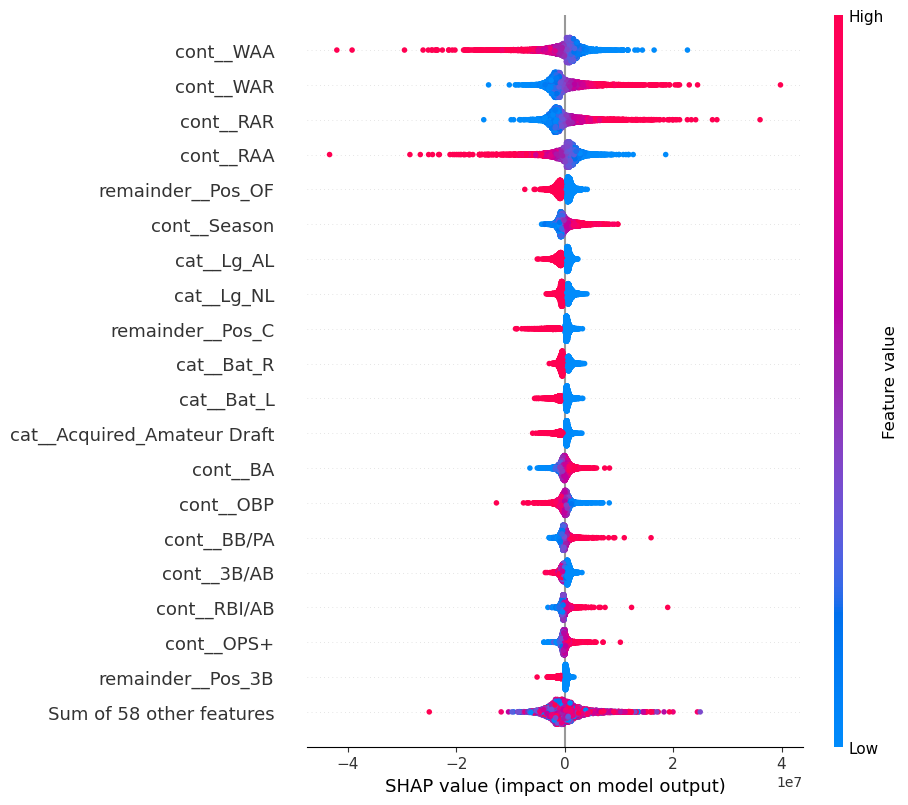

In [30]:
shap.plots.beeswarm(exp, max_display = 20)

In [31]:
import matplotlib.pyplot as plt

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


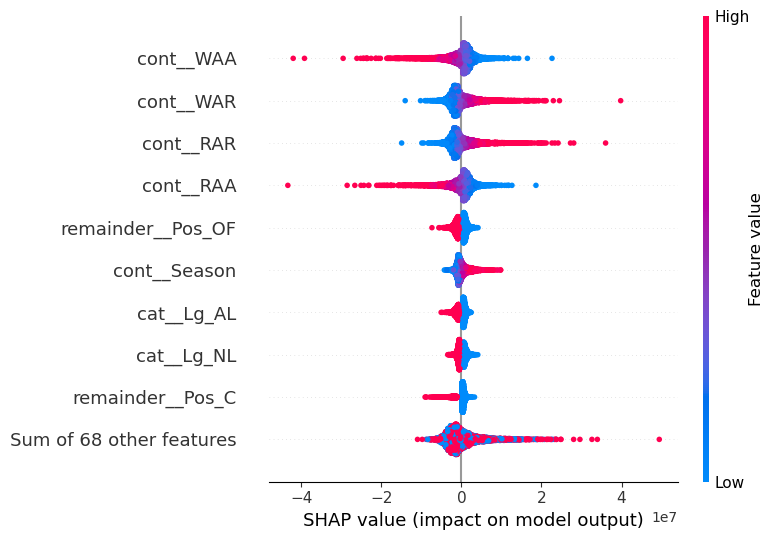

In [32]:
shap.plots.beeswarm(exp, max_display = 10, show = False)
plt.tight_layout()
plt.savefig('images/beeswarm.png')